In [137]:
%pip install torch numpy pandas matplotlib pytorch-lightning librosa


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [138]:
# imports
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import typing

# Project Overview and Motivation

### Modeling Effects Pedals

Since the 1950s, guitarists and other instrumentalists have used effects pedals to achieve certain sounds from their instruments, from overdrive and distortion to reverb and delay. These effects are often encapsulated in physical pedals, each one with different analog circuitry, down to the types of capacitors that go on the pedals, to achieve these different sounds. Musicians will then use these pedals downstream of their instrument signal to apply the effect.

Here is a common signal flow for an overdrive pedal with a guitar:

![signal flow](images/signal-flow.png "Signal Flow")

The guitar produces an input signal, which goes through the overdrive pedal, applying the overdriven effect (a sound that is more distorted and louder) on the raw signal, which then goes through the amplifier, which applies its own sound, and outputs it over its speakers.

### Creating An Effects Pedal Model

Now, the goal of this project is to use machine learning to replace the pedal in the signal chain with software -- a model that emulates the same sound that musicians come to expect when using that pedal.

![signal flow in software](images/signal-flow-sw.png "Signal Flow in Software")

Using an input waveform from the guitar, and an output waveform from the guitar pedal, we can perform supervised learning to achieve this pedal model, completely cutting out the physical pedal in the signal chain altogether!

### Our Setup

For this project, we wanted to model a Boss DS-2 Turbo Distortion Pedal. To achieve this setup and record our dataset, we split the output of the guitar -- one side goes into an input of an audio interface so we can record the raw guitar signal, and the other goes to the pedal, the output of which goes to another input of the audio interface so we can record the distorted guitar signal.


## Analyze audio signals
Our first step is to actually analyze our audio signals. We can use librosa, a package for audio analysis, for this task. What we are essentially doing here is reading from our .wav files and plotting that data on a graph which depicts the amplitude of the wave over time.

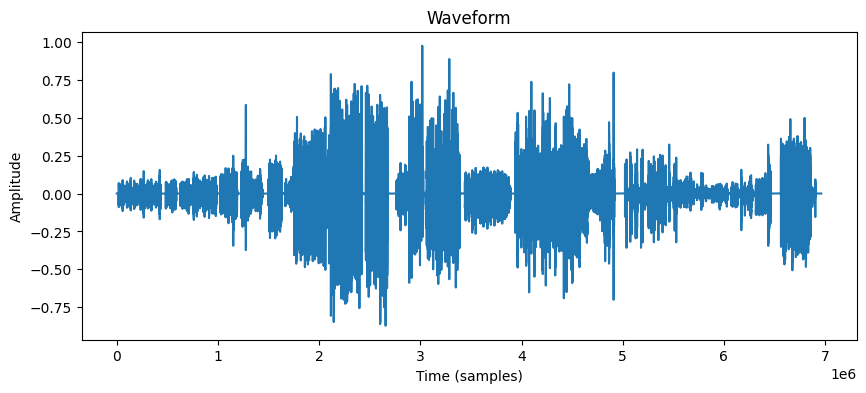

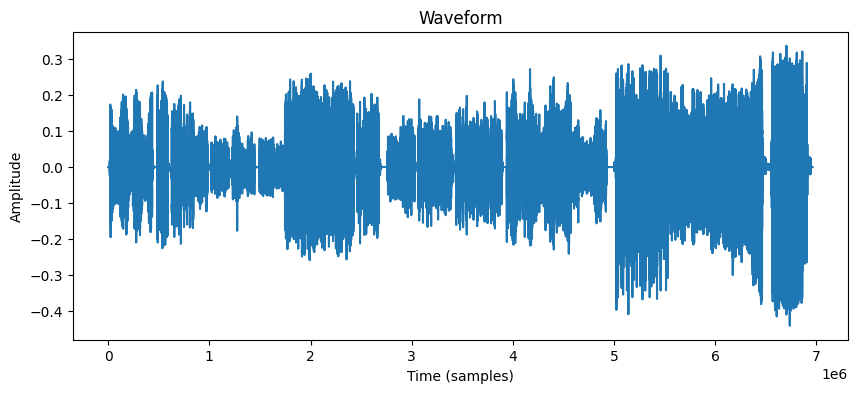

In [139]:
# data exploration to expand on later

def load_audio(file_path: str) -> tuple:
    audio_signal, sampling_rate = librosa.load(file_path, sr=None)
    return audio_signal, sampling_rate

def plot_waveform(wave: np.ndarray) -> None:
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(wave)
    plt.title("Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

# inp_audio_signal, inp_sampling_rate = load_audio("./data/ML_Pedal_Input.wav")
# out_audio_signal, out_sampling_rate = load_audio("./data/ML_Pedal_Output.wav")

# Downsampled audio signals
inp_audio_signal, inp_sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")
out_audio_signal, out_sampling_rate = load_audio("./data/ML_Pedal_Output_DS.wav")

# # Make signal divisible by sample rate
# inp_audio_signal = inp_audio_signal[:-(len(inp_audio_signal) % inp_sampling_rate)]
# out_audio_signal = out_audio_signal[:-(len(out_audio_signal) % out_sampling_rate)]

plot_waveform(inp_audio_signal)
plot_waveform(out_audio_signal)

### Analysis
as can be seen here, the graph for input and output datasets differ drastically

# Machine Learning
We are planning on using a neural network for our machine learning model. 

In [140]:
# turn into tensors for torch

def to_tensor(data: np.ndarray) -> torch.Tensor:
    return torch.tensor(data, dtype=float).unsqueeze(1)

inp_tensor = to_tensor(inp_audio_signal)
out_tensor = to_tensor(out_audio_signal)

# Shorten tensors to 15 seconds
inp_tensor = inp_tensor[:inp_sampling_rate * 60]
out_tensor = out_tensor[:out_sampling_rate * 60]

print(f"Input Tensor Shape: {inp_tensor.shape}")
print(f"Target Tensor Shape: {out_tensor.shape}")

Input Tensor Shape: torch.Size([960000, 1])
Target Tensor Shape: torch.Size([960000, 1])


## Neural Network
WaveNet is our initial neural network for this project. There are five layers in this model, and we will explain our reasoning for using these five layers shortly
1. Input Layer
    - this is our input layer that takes in our raw audio signal and converts it via a 1x1 convolution, which transforms a single-channel raw waveform into multiple feature maps. Feature maps are the output of the 1x1 convolution that lets the model decide which features actually matter (pitch, amplitude, etc.). This makes it so that we do not have to manually select our features, which, due to the vast domain of audio, could lead our model to be overfitted.
2. Dilated Convolution Layers:
3. Residual Connections
4. Skip Connections
5. Output Layer


In [141]:
cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if cuda_available else "cpu")

print(f"Device: {device}")

Device: cuda


In [142]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()
        padding = dilation * (kernel_size - 1)
        self.dilated_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size, dilation=dilation, padding=padding
        )
        self.skip_conv = nn.Conv1d(out_channels, out_channels, 1)
        self.residual_conv = nn.Conv1d(out_channels, in_channels, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.dilated_conv(x)
        skip = self.skip_conv(out)
        residual = self.residual_conv(out)
        out = self.activation(out + skip)  # Add residual + skip, then apply activation
        return out, residual


class WaveNet(nn.Module):
    def __init__(
        self,
        num_channels: int = 32,
        dilation_depth: int = 4,
        kernel_size: int = 2,
        num_classes: int = 256,
    ):
        super(WaveNet, self).__init__()
        self.input_layer = nn.Conv1d(
            in_channels=1, out_channels=num_channels, kernel_size=1
        )

        self.residual_blocks = nn.ModuleList()
        dilation = 1
        for i in range(dilation_depth):
            self.residual_blocks.append(
                ResidualBlock(num_channels, num_channels, kernel_size, dilation)
            )
            dilation *= 2  # Double the dilation at each block

        self.output_layer = nn.Conv1d(num_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.input_layer(x)
        skip_connections = []
        for block in self.residual_blocks:
            out, skip = block(out)
            # skip_connections.append(skip)

            # # Ensure the skip connections have the same shape
            # out = sum(skip_connections)  # Sum over the skip connections
        out = self.output_layer(out)
        return out

In [143]:
batch_size = 128
learning_rate = 0.001
num_epochs = 100

num_channels = 32
dilation_depth = 4
kernel_size = 2
num_classes = 2 ** 8

In [144]:
def train_model(model: nn.Module, dataLoader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int = 10) -> None:
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataLoader:
            optimizer.zero_grad()

            inputs = inputs.unsqueeze(1)
            targets = targets.unsqueeze(1)

            outputs = model(inputs)

            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

In [145]:
# training loop

# class for pytorch
class Audio(Dataset):
    def __init__(self, inputs: Tensor, outputs: Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self) -> int:
        return len(self.inputs)

    def __getitem__(self, index: int) -> tuple:
        return self.inputs[index], self.outputs[index]

model = WaveNet(num_channels, dilation_depth, kernel_size, num_classes)

# inp_tensor = inp_tensor.to(device)
# out_tensor = out_tensor.to(device)
# model = model.double().to(device)

training_dataset = Audio(inp_tensor, out_tensor)
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Load model
# model.load_state_dict(torch.load("wavenet_guitar_model.pth"))

# train_model(model, train_loader, criterion, optimizer, num_epochs)


In [146]:
torch.save(model.state_dict(), "wavenet_guitar_model.pth")
print("Model saved successfully.")

Model saved successfully.


In [147]:
model = WaveNet()  # Ensure this matches the architecture used during training

# Load the saved state dictionary
model.load_state_dict(torch.load("wavenet_guitar_model.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


/tmp/ipykernel_324327/76303354.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("wavenet_guitar_model.pth"))


In [148]:
class SimpleLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, batch_size):
        super(SimpleLSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.last_layer = nn.Linear(num_classes, num_classes)

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).double().to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).double().to(device)

        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n = h_n.view(-1, self.hidden_size)

        out = self.activation(h_n)
        out = self.fc(out)
        out = self.activation(out)
        out = self.last_layer(out)

        return out

    def train_epoch(self, data_loader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer) -> None:
        self.train()
        for inputs, targets in data_loader:
            optimizer.zero_grad()

            outputs = self(inputs)

            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

    def save_model(self, path: str) -> None:
        torch.save(self.state_dict(), path)
        print("Model saved successfully.")

    def load_model(self, path: str) -> None:
        self.load_state_dict(torch.load(path))

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        model.eval()

        seq_length = x.shape[0] // self.batch_size

        # Reshape input tensor to LSTM input shape
        x = x.reshape(self.batch_size, seq_length, 1).double().to(device)

        with torch.no_grad():
            return self(x)

num_classes = 1
batch_size = 100
hidden_size = 3
num_layers = 1
seq_length = len(inp_tensor) // batch_size
num_epochs = 10

learning_rate = 0.001

print(f"Input Tensor Shape: {inp_tensor.shape}")
print(f"Target Tensor Shape: {out_tensor.shape}")
print(f"Sequence Length: {seq_length}")

lstm_model = SimpleLSTM(num_classes, num_classes, hidden_size, num_layers, seq_length, batch_size)
lstm_model = lstm_model.double().to(device)

# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

inp_tensor_lstm = inp_tensor.reshape(batch_size, seq_length, 1).double().to(device)
out_tensor_lstm = out_tensor.clone().double().to(device)

training_dataset = list(zip(inp_tensor_lstm, out_tensor_lstm))

dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    lstm_model.train_epoch(dataloader, criterion, optimizer)

Input Tensor Shape: torch.Size([960000, 1])
Target Tensor Shape: torch.Size([960000, 1])
Sequence Length: 9600
Epoch: 1, Loss: 0.04611871103429621
Epoch: 2, Loss: 0.04569020569604408
Epoch: 3, Loss: 0.045263753282682694
Epoch: 4, Loss: 0.04483938836357728
Epoch: 5, Loss: 0.04441714488873892
Epoch: 6, Loss: 0.043997056108488516
Epoch: 7, Loss: 0.043579154496579536
Epoch: 8, Loss: 0.043163471677335495
Epoch: 9, Loss: 0.04275003835730569
Epoch: 10, Loss: 0.042338884261882814


In [169]:
import soundfile as sf
import librosa

def save_audio_file(input_signal: torch.Tensor, new_sampling_rate: int, path: str) -> None:
    input_signal = input_signal.squeeze().detach().cpu().numpy()
    print(input_signal.shape)
    output_signal = input_signal / np.max(np.abs(input_signal))
    sf.write(path, output_signal, new_sampling_rate)


In [170]:
lstm_model.save_model("lstm_guitar_model.pth")

Model saved successfully.


In [172]:
# Predict
validation_audio_signal, validation_sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")

validation_audio_signal = validation_audio_signal[:validation_sampling_rate * 60]

validation_audio_signal = to_tensor(validation_audio_signal).to(device).double()

predicted_audio_signal = lstm_model.predict(validation_audio_signal)

save_audio_file(predicted_audio_signal, validation_sampling_rate, "predicted_audio.wav")

(100,)


In [ ]:
new_audio_signal, new_sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")

# new_audio_signal, new_|sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")

# Ensure input tensor has the correct type (float32)
new_audio_signal = to_tensor(new_audio_signal).to(device).double()

# Reshape to (1, 1, sequence_length) for Conv1d
new_audio_signal = new_audio_signal.unsqueeze(0).transpose(1, 2)

print(new_audio_signal.shape)  # Verify the shape is (1, 1, sequence_length)

# Perform inference
with torch.no_grad():
    output = model(new_audio_signal)

# Post-process the output
output_signal = output.squeeze().numpy()  # Remove extra dimensions


torch.Size([1, 1, 6962279])


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 6962279

In [ ]:
%pip install soundfile


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


(6962279,)
(19189795,)
Output saved as 'output_signal.wav'
